## Agentic RAG With LangGraph

In [1]:
import os
from typing import TypedDict, List
from langgraph.graph import StateGraph, END
from langchain_ollama import ChatOllama
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document

e:\Git_and_GitHub\LangGraphTut\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
# Initialize models - using Ollama (no API key need
ollama_model = os.getenv("OLLAMA_MODEL")

llm = ChatOllama(model=ollama_model, temperature=0)
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)

In [4]:
llm

ChatOllama(model='qwen2.5:0.5b', temperature=0.0)

## State Definition

In [5]:
class AgentState(TypedDict):
    question: str
    documents: List[Document]
    answer: str
    needs_retrieval: bool

In [6]:
### Sample Docuemnt And VectorStore
# Sample documents for demonstration
sample_texts = [
    "LangGraph is a library for building stateful, multi-actor applications with LLMs. It extends LangChain with the ability to coordinate multiple chains across multiple steps of computation in a cyclic manner.",
    "RAG (Retrieval-Augmented Generation) is a technique that combines information retrieval with text generation. It retrieves relevant documents and uses them to provide context for generating more accurate responses.",
    "Vector databases store high-dimensional vectors and enable efficient similarity search. They are commonly used in RAG systems to find relevant documents based on semantic similarity.",
    "Agentic systems are AI systems that can take actions, make decisions, and interact with their environment autonomously. They often use planning and reasoning capabilities."
]

documents=[Document(page_content=text) for text in sample_texts]

##create vector store
vectorstore = FAISS.from_documents(documents, embeddings)
retriever = vectorstore.as_retriever(k=3)

### Agents function

In [7]:
def decide_retrieval(state: AgentState) -> AgentState:
    """
    Decide if we need to retrieve documents based on the question
    """
    question = state["question"]
    
    # Simple heuristic: if question contains certain keywords, retrieve
    retrieval_keywords = ["what", "how", "explain", "describe", "tell me"]
    needs_retrieval = any(keyword in question.lower() for keyword in retrieval_keywords)
    
    return {**state, "needs_retrieval": needs_retrieval}

In [8]:
def retrieve_documents(state: AgentState) -> AgentState:
    """
    Retrieve relevant documents based on the question
    """
    question = state["question"]
    documents = retriever.invoke(question)
    
    return {**state, "documents": documents}

In [9]:
def generate_answer(state: AgentState) -> AgentState:
    """
    Generate an answer using the retrieved documents or direct response
    """
    question = state["question"]
    documents = state.get("documents", [])
    
    if documents:
        # RAG approach: use documents as context
        context = "\n\n".join([doc.page_content for doc in documents])
        prompt = f"""Based on the following context, answer the question:

Context:
{context}

Question: {question}

Answer:"""
    else:
        # Direct response without retrieval
        prompt = f"Answer the following question: {question}"
    
    response = llm.invoke(prompt)
    answer = response.content
    
    return {**state, "answer": answer}

## conditional Logic

In [10]:
def should_retrieve(state: AgentState) -> str:
    """
    Determine the next step based on retrieval decision
    """
    if state["needs_retrieval"]:
        return "retrieve"
    else:
        return "generate"

## build the Graph

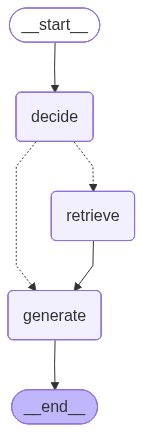

In [11]:
# Create the state graph
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("decide", decide_retrieval)
workflow.add_node("retrieve", retrieve_documents)
workflow.add_node("generate", generate_answer)

# Set entry point
workflow.set_entry_point("decide")

# Add conditional edges
workflow.add_conditional_edges(
    "decide",
    should_retrieve,
    {
        "retrieve": "retrieve",
        "generate": "generate"
    }
)

# Add edges
workflow.add_edge("retrieve", "generate")
workflow.add_edge("generate", END)

# Compile the graph
app = workflow.compile()
app

## test the Agentic System

In [12]:
def ask_question(question: str):
    """
    Helper function to ask a question and get an answer
    """
    initial_state = {
        "question": question,
        "documents": [],
        "answer": "",
        "needs_retrieval": False
    }
    
    result = app.invoke(initial_state)
    return result

In [13]:
# Test with a question that should trigger retrieval
question1 = "What is LangGraph?"
result1 = ask_question(question1)
result1

{'question': 'What is LangGraph?',
 'documents': [Document(id='31662020-feee-4411-a842-ed0597445db7', metadata={}, page_content='LangGraph is a library for building stateful, multi-actor applications with LLMs. It extends LangChain with the ability to coordinate multiple chains across multiple steps of computation in a cyclic manner.'),
  Document(id='b533608a-a29f-4b18-9ff6-99cf86cb62e8', metadata={}, page_content='RAG (Retrieval-Augmented Generation) is a technique that combines information retrieval with text generation. It retrieves relevant documents and uses them to provide context for generating more accurate responses.'),
  Document(id='10c51189-1806-4497-924f-0d7013ead4b1', metadata={}, page_content='Vector databases store high-dimensional vectors and enable efficient similarity search. They are commonly used in RAG systems to find relevant documents based on semantic similarity.'),
  Document(id='bfbb7eab-71c9-4382-accc-10facb4488be', metadata={}, page_content='Agentic system

In [14]:
# Test with another question
question2 = "How does RAG work?"
result2 = ask_question(question2)

print(f"Question: {question2}")
print(f"Retrieved documents: {len(result2['documents'])}")
print(f"Answer: {result2['answer']}")
print("\n" + "="*50 + "\n")

Question: How does RAG work?
Retrieved documents: 4
Answer: RAG (Retrieval-Augmented Generation) works by combining information retrieval with text generation. It first retrieves relevant documents from a knowledge base or database using semantic similarity, then uses these documents to generate more accurate responses based on the context provided by the user. The process involves:

1. Retrieving relevant documents: RAG systems use vector databases (such as those stored in LangGraph) to find and retrieve high-dimensional vectors that represent relevant information.

2. Generating responses: Once the system has retrieved the relevant documents, it uses these vectors to generate more accurate responses based on the context provided by the user. This involves understanding the context of the question or statement being asked and using the retrieved documents to provide a response that is both relevant and coherent.

3. Contextual information: RAG systems often use contextual information 